In [26]:
import random
import cv2
import torch
import torchvision
import numpy as np

from matplotlib import pyplot as plt
from PIL import Image

import segmentation_models_pytorch as smp
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F

import pytorch_lightning as pl

from augmentations import (
    AffineAugmenter,
    BrightnessContrastAugmenter,
    BlurAugmenter,
    FlipAugmenter,
    RandomAugmentation,
)
import cvmade

USE_CUDA = torch.cuda.is_available()


def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

In [61]:
class TargetTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, mask):
        mask = self.transform(mask)
        return (mask > 0).type(torch.long)


transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])
target_transform = TargetTransform(transform)

train_dataset = torchvision.datasets.VOCSegmentation(
    "dataset/",
    image_set="train",
    transform=transform,
    target_transform=target_transform,
    download=False,
    year="2012",
)
val_dataset = torchvision.datasets.VOCSegmentation(
    "dataset/",
    image_set="val",
    transform=transform,
    target_transform=target_transform,
    download=False,
    year="2012",
)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=8, shuffle=True, drop_last=True
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=8, shuffle=False
)

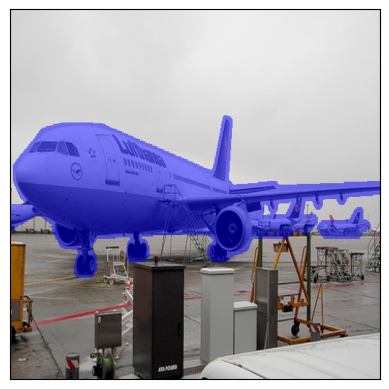

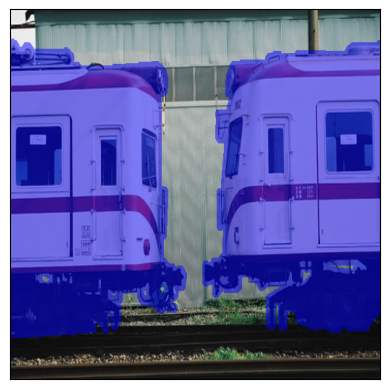

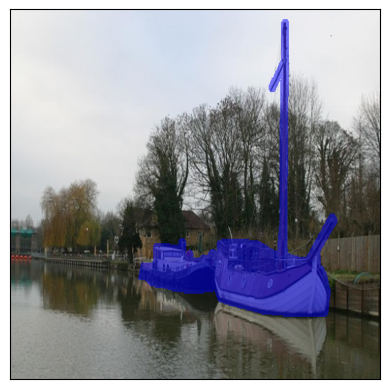

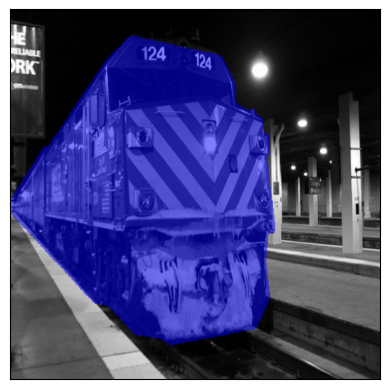

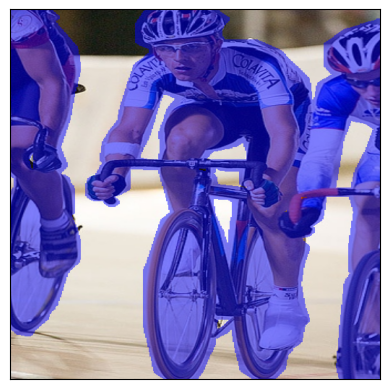

In [71]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def plot_image_mask(img, mask, alpha=0.5):
    img = (img * 255).to(torch.uint8)
    obj_ids = torch.unique(mask)
    obj_ids = obj_ids[1:]
    mask = mask == obj_ids[:, None, None]

    show(draw_segmentation_masks(img, masks=mask, alpha=alpha, colors="blue"))


for i in range(5):
    img, mask = val_dataset[i]
    plot_image_mask(img, mask)

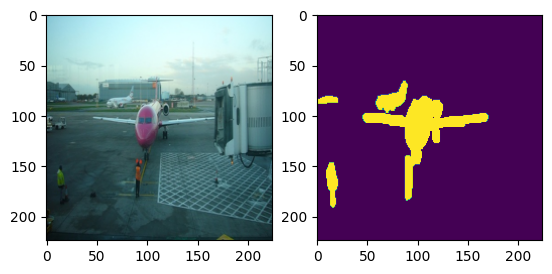

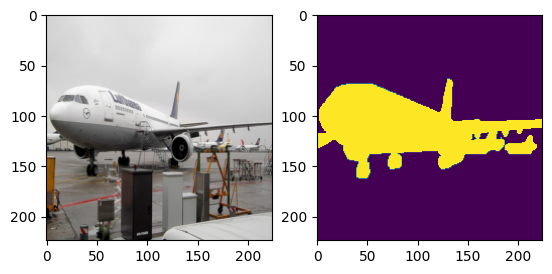

In [25]:
# def draw(im, segm):
#     f, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.imshow(im.permute(1, 2, 0))
#     ax2.imshow(segm.permute(1, 2, 0))
#     plt.show()


# draw(*train_dataset[0])
# draw(*val_dataset[0])

Number of classes: 2
Mask values: {0, 18, 255}


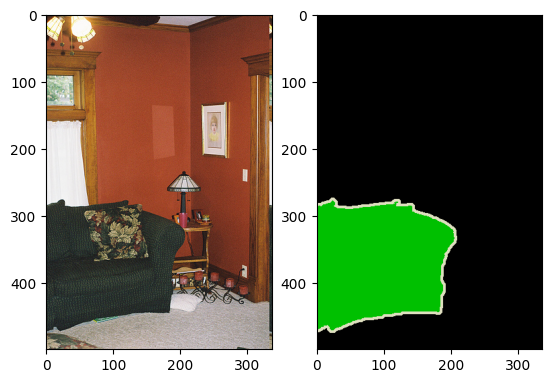

In [15]:
DATA_ROOT = "."
VOC_YEAR = "2012"
LABELS = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted_plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]
MULTICLASS = (
    False  # Если False, отделяем объекты от фона, иначе распознаем класс объектов.
)
NUM_CLASSES = len(LABELS) if MULTICLASS else 2
print("Number of classes:", NUM_CLASSES)

# Посмотрим на валидационную часть корпуса.
valset_raw = VOCSegmentation(DATA_ROOT, VOC_YEAR, "val", download=False)

image, mask = valset_raw[random.randint(0, len(valset_raw) - 1)]
print("Mask values:", set(np.array(mask).flatten().tolist()))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [16]:
class Scaler(object):
    """Отмасштабировать изображения сохранив пропорции.

    Пустые места будут заполнены отражениями.

    Аргументы:
        image: Изображение в HWC формате.
        size: Требуемый размер, пара W, H.
    """

    def __init__(self, size):
        self._size = size
        self._padding = 0

    def set_padding(self, padding):
        self._padding = padding

    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        grayscale = len(image.shape) == 2
        if grayscale:
            image = image[..., None]
        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2
        # Используем zeros на случай маленьких изображений.
        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(
            image,
            (sw, sh),
            interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
            dst=result[offset_y : offset_y + sh, offset_x : offset_x + sw],
        )

        # Отразить.
        result[offset_y : offset_y + sh, :offset_x] = result[
            offset_y : offset_y + sh, offset_x : 2 * offset_x
        ][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y : offset_y + sh, offset_x + sw :] = result[
            offset_y : offset_y + sh, sw + offset_x - offset_end : sw + offset_x
        ][:, ::-1]

        result[:offset_y] = result[offset_y : 2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh :] = result[sh + offset_y - offset_end : sh + offset_y][
            ::-1
        ]

        if grayscale:
            result = result[:, :, 0]
        return result


def remove_borders_inplace(mask):
    mask[mask == 255] = 0
    return mask


class VOCDataset(torch.utils.data.Dataset):
    """Обертка для стандартного класса, которая форматирует данные."""

    def __init__(
        self,
        root,
        year,
        image_size,
        multiclass=MULTICLASS,
        download=False,
        augment=False,
        train=False,
        train_fraction=0.8,
        padding=0,
    ):
        """Создать корпус.

        Аргументы:
            root: Путь до папки для хранения данных.
            year: 2007 или 2012.
            image_size: Ширина и высота изображений.
            download: Скачать корпус, если он не найден в папке.
            augment: Применить аугментации.
            train: Выделить train часть, иначе validation.
            train_fraction: Доля тренировочных примеров.
            padding: Добавить дополнительный зеркальынй паддинг к изображению.
        """
        self._dataset = VOCSegmentation(root, str(year), "trainval", download=download)
        self._image_size = np.array(image_size)
        self._multiclass = multiclass
        self._padding = padding

        ids = list(range(len(self._dataset)))
        random.seed(0)
        random.shuffle(ids)
        train_size = int(len(ids) * train_fraction)
        self._indices = ids[:train_size] if train else ids[train_size:]

        self._image_scaler = Scaler(image_size)
        self._mask_scaler = Scaler(image_size)
        if augment:
            self._augmenter = RandomAugmentation(
                AffineAugmenter(),
                BrightnessContrastAugmenter(),
                BlurAugmenter(),
                FlipAugmenter(),
            )
        else:
            self._augmenter = lambda image, mask: (image, mask)

    @property
    def image_size(self):
        return self._image_size + self._padding * 2

    def set_padding(self, padding):
        self._padding = padding
        self._image_scaler.set_padding(padding)
        self._mask_scaler.set_padding(padding)

    def __len__(self):
        return len(self._indices)

    def __getitem__(self, idx):
        image, mask = self._dataset[self._indices[idx]]
        image = np.asarray(image)
        mask = np.array(mask)
        remove_borders_inplace(mask)
        if not self._multiclass:
            mask[mask > 0] = 1
        image = self._image_scaler(image)
        mask = self._mask_scaler(mask)
        image, mask = self._augmenter(image, mask)
        image = cvmade.image.image_to_torch(image).float() - 0.5
        mask = cvmade.image.image_to_torch(mask[..., None]).long()[0]
        return image, mask


IMAGE_SIZE = 512  # В исходной статье U-Net применяется к изображениям размера 572.

# Корпус был загружен выше, download = False.
trainset = VOCDataset(
    DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE), multiclass=MULTICLASS, train=True
)
valset = VOCDataset(
    DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE), multiclass=MULTICLASS, train=False
)
print("Image size:", IMAGE_SIZE)
print("Train set size:", len(trainset))
print("Validation set size:", len(valset))

Image size: 512
Train set size: 2330
Validation set size: 583


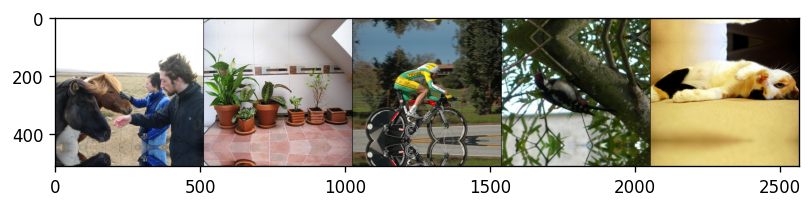

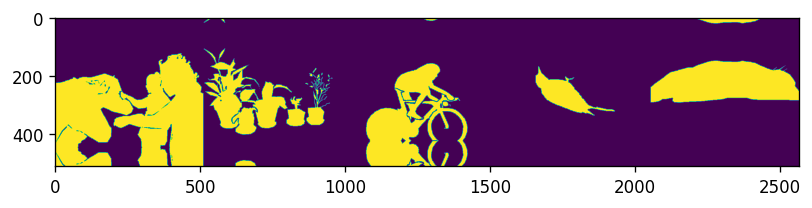

In [17]:
def show_dataset(dataset):
    images = []
    masks = []
    for _ in range(5):
        i = random.randint(0, len(valset) - 1)
        if len(images):
            separator = np.zeros((dataset.image_size[0], 2, 3), dtype=np.uint8)
            images.append(separator)
            masks.append(separator[:, :, 0])
        image, mask = dataset[i]
        images.append(cvmade.image.image_to_numpy(image))
        masks.append(cvmade.image.image_to_numpy(mask[None, ...])[..., 0])

    set_figure_size()
    plt.imshow(np.concatenate(images, axis=1))
    plt.show()
    set_figure_size()
    plt.imshow(np.concatenate(masks, axis=1))
    plt.show()


valset.set_padding(0)
show_dataset(trainset)

In [15]:
def crop_images(predicted, masks_or_images):
    """Если выход больше или меньше чем исходное изображение,
    вырезать центральную часть из обоих, чтобы размеры совпадали.
    """
    if len(masks_or_images.shape) == 3:
        predicted, masks = crop_images(predicted, masks_or_images.unsqueeze(1))
        return predicted, masks[:, 0]
    images = masks_or_images
    if (len(predicted.shape) != 4) or (len(images.shape) != 4):
        raise ValueError("Expected tensors of shape BCHW")
    bi, ci, hi, wi = images.shape
    bp, cp, hp, wp = predicted.shape
    offset = (abs(hi - hp) // 2, abs(wi - wp) // 2)
    if hp < hi:
        images = images[:, :, offset[0] : offset[0] + hp]
    else:
        predicted = predicted[:, :, offset[0] : offset[0] + hi]
    if wp < wi:
        images = images[:, :, :, offset[1] : offset[1] + wp]
    else:
        predicted = predicted[:, :, :, offset[1] : offset[1] + wi]
    return predicted, images

In [38]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

unet_pretrained = smp.Unet(
    "resnet34",
    encoder_weights="imagenet",
    classes=NUM_CLASSES if NUM_CLASSES > 2 else 1,
)

unet_pretrained.eval()
sample_input = torch.zeros((1, 3, 1024, 1024))
if USE_CUDA:
    sample_input = sample_input.cuda()
    unet_pretrained.cuda()
with torch.no_grad():
    sample_output = unet_pretrained(sample_input)
pretrained_padding = (sample_input.shape[-1] - sample_output.shape[-1]) // 2

trainset.set_padding(pretrained_padding)
valset.set_padding(pretrained_padding)

Trainset


<Figure size 960x720 with 0 Axes>

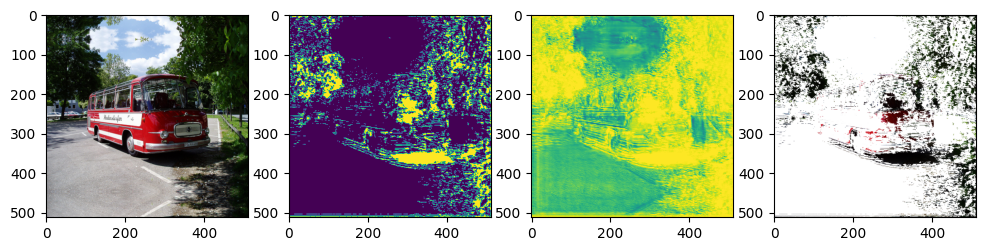

<Figure size 960x720 with 0 Axes>

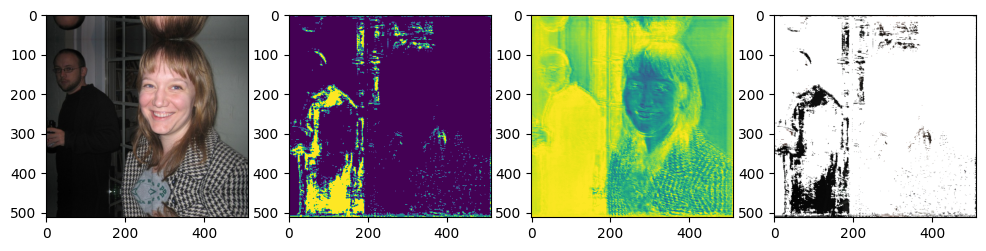

<Figure size 960x720 with 0 Axes>

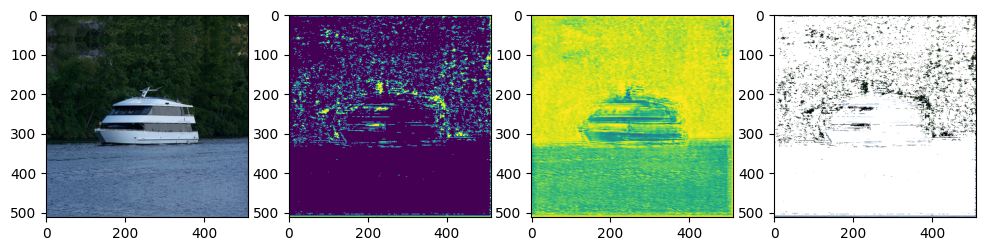

<Figure size 960x720 with 0 Axes>

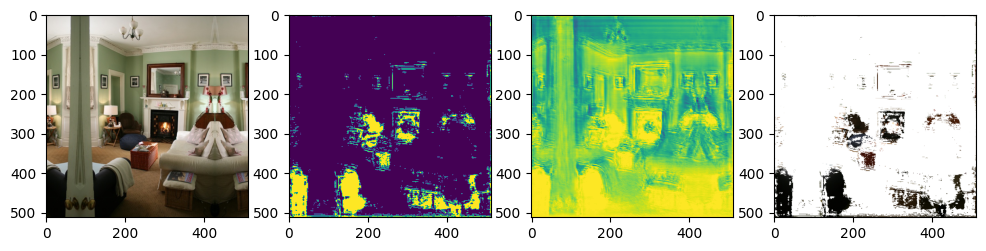

<Figure size 960x720 with 0 Axes>

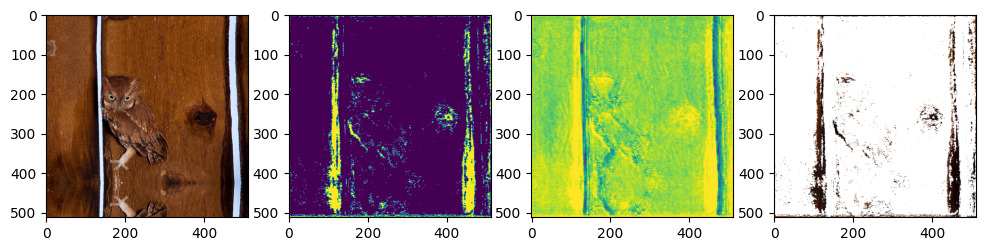

Valset


<Figure size 960x720 with 0 Axes>

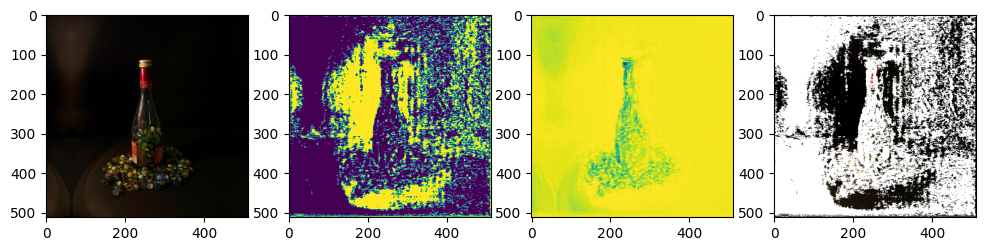

<Figure size 960x720 with 0 Axes>

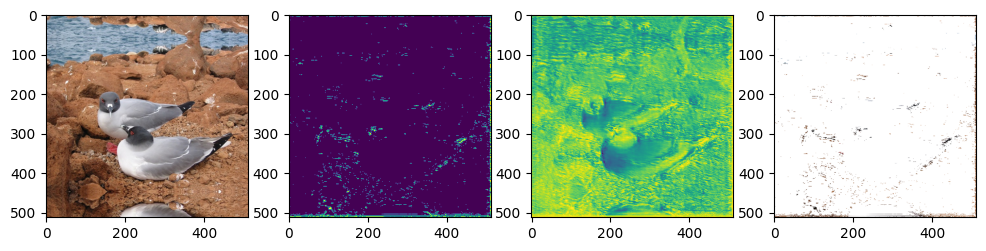

<Figure size 960x720 with 0 Axes>

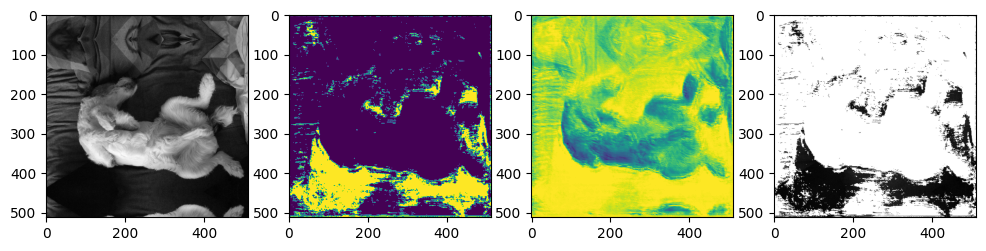

<Figure size 960x720 with 0 Axes>

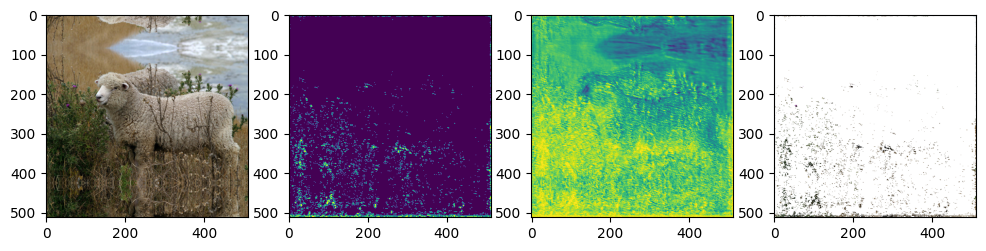

<Figure size 960x720 with 0 Axes>

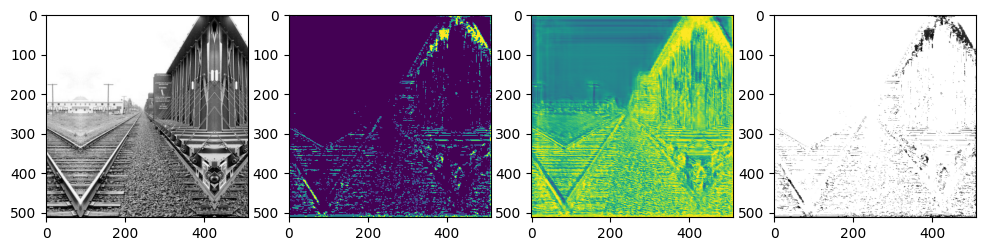

In [26]:
def show_segmentations(model, dataset, n=5):
    model.eval()
    if USE_CUDA:
        model.cuda()
    for _ in range(n):
        image, mask_gt = dataset[random.randint(0, len(dataset) - 1)]
        if USE_CUDA:
            image = image.cuda()
            mask_gt = mask_gt.cuda()
        with torch.no_grad():
            predicted = model(image.unsqueeze(0))[0]  # CHW.
            predicted, image = crop_images(predicted.unsqueeze(0), image.unsqueeze(0))
            predicted, image = predicted[0], image[0]
            c = predicted.shape[0]
            if c == 1:
                predicted = torch.nn.functional.logsigmoid(predicted)
                aggregated = predicted[0]
                predicted_labels = predicted[0] > np.log(0.5)
            else:
                predicted = torch.nn.functional.log_softmax(predicted, 0)
                aggregated = torch.logsumexp(predicted[1:], axis=0)
                predicted_labels = predicted.max(0)[1]
        aggregated = aggregated.cpu().numpy()
        predicted_labels = predicted_labels.cpu().numpy().astype(np.uint8)
        image = cvmade.image.image_to_numpy(image)
        mask = (predicted_labels > 0)[..., None]
        selected = image * mask + 255 * (1 - mask)

        %matplotlib inline
        if c != 1:
            print("Classes:", [LABELS[i] for i in set(predicted_labels.flatten().tolist())])
        set_figure_size()
        fig, axs = plt.subplots(1, 4, figsize=(12, 6))
        axs[0].imshow(image)
        axs[1].imshow(predicted_labels)
        axs[2].imshow(aggregated)
        axs[3].imshow(selected)
        plt.show()
        
print("Trainset")
show_segmentations(unet_pretrained, trainset)

print("Valset")
show_segmentations(unet_pretrained, valset)

In [42]:
# class Module(pl.LightningModule):
#     def __init__(
#         self,
#         model,
#         loss_fn,
#         optimizer_fn,
#         trainset,
#         testset,
#         lr_scheduler_fn=None,
#         batch_size=16,
#     ):
#         super().__init__()
#         self._model = model
#         self._optimizer_fn = optimizer_fn
#         self._lr_scheduler_fn = lr_scheduler_fn
#         self._criterion = loss_fn()
#         self._batch_size = batch_size
#         self._trainset = trainset
#         self._testset = testset

#     def forward(self, input):
#         return self._model(input)

#     def training_step(self, batch, batch_idx):
#         # training_step defines the train loop. It is independent of forward
#         x, y = batch
#         logits = self._model(x)
#         loss = self._criterion(logits, y)
#         self.logger.experiment.add_scalars(
#             "loss", {"train": loss}, global_step=self.global_step
#         )
#         return loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         logits = self._model(x)
#         loss = self._criterion(logits, y)
#         self.logger.experiment.add_scalars(
#             "loss", {"val": loss}, global_step=self.global_step
#         )

#     def train_dataloader(self):
#         return torch.utils.data.DataLoader(
#             self._trainset,
#             batch_size=self._batch_size,
#             shuffle=True,
#             drop_last=True,
#             num_workers=2,
#         )

#     def val_dataloader(self):
#         return torch.utils.data.DataLoader(
#             self._testset, batch_size=self._batch_size, shuffle=False, num_workers=2
#         )

#     def configure_optimizers(self):
#         optimizer = self._optimizer_fn(self._model)
#         scheduler = self._lr_scheduler_fn(optimizer)
#         if scheduler:
#             return [optimizer], [scheduler]
#         else:
#             return optimizer


# def train_model(
#     model,
#     loss_fn,
#     optimizer_fn,
#     trainset,
#     testset,
#     lr_scheduler_fn=None,
#     batch_size=4,
#     eval_steps=250,
#     num_epochs=1,
# ):
#     model = Module(
#         model, loss_fn, optimizer_fn, trainset, testset, lr_scheduler_fn, batch_size
#     )
#     trainer = pl.Trainer(
#         accelerator="auto", max_epochs=num_epochs, val_check_interval=eval_steps
#     )
#     trainer.fit(model)


class BCELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self._bce = torch.nn.BCEWithLogitsLoss()

    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c != 1:
            raise ValueError(
                "{} не подходит для многоклассовой классификации".format(type(self))
            )
        # predicted: float32, BCHW.
        # masks: long, BHW.
        loss = self._bce(predicted.squeeze(1), masks.float())

        return loss


def make_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=1e-4)

In [45]:
import seminar

loss_fn = BCELoss

trainset.set_padding(pretrained_padding)
valset.set_padding(pretrained_padding)

seminar.train_model(
    model=unet_pretrained,
    loss_fn=loss_fn,
    optimizer_fn=make_optimizer,
    trainset=trainset,
    testset=valset,
    lr_scheduler_fn=lambda opt: None,
    eval_steps=500,
    batch_size=4,
    num_epochs=1,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs

  | Name       | Type    | Params
---------------------------------------
0 | _model     | Unet    | 24.4 M
1 | _criterion | BCELoss | 0     
---------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

AttributeError: Can't pickle local object 'VOCDataset.__init__.<locals>.<lambda>'